# Linear Regression: Simulation and Calculation
by [HydraulicSheep](https://github.com/HydraulicSheep)

In today's landscape of overwhelming developments in 'Machine Learning' and 'AI', it's easy to forget about the simple powerhouses of the statistics world. One of these is ***Linear Regression***.

References:

http://www.stat.yale.edu/Courses/1997-98/101/linreg.htm **[1]**

https://people.sc.fsu.edu/~jburkardt/datasets/regression/regression.html **[2]**

http://seismo.berkeley.edu/~kirchner/eps_120/Toolkits/Toolkit_10.pdf **[3]**

## Simple Linear Regression

Linear regression is simply the fitting of a linear model to a dataset - (making the assumption it is linear). Here, standard linear equations are used.

$$\textbf{y} = mx + c$$

Now, for nearly all datasets (except pure straight lines), it is impossible to find a straight line that passes through every point - that's the whole point of using regression. Therefore, we introduce an **'external error'** term to which we attribute differences between our observation and the quantity's true value.

$$\textbf{y}_i= mx_i + c + \varepsilon_i$$

This represents just one datapoint in the data set - $\{(x_1,y_1),(x_2,y_2)...(x_n,y_n)\}$. Here, m and c are the constants we are seeking - the gradient and y-intercept that define the regression line.

So, rearranging, we get: $$\hat{\varepsilon}_i = \textbf{y}_i - mx_i - c$$

Note that the switch from $\varepsilon_i$ to $\hat{\varepsilon}_i$ is intentional: the hat refers to a ***residual*** - the difference between the observation and model value - whereas the non-hatted version refers to an ***error*** - the difference between the observation and true value. The model aims to minimize these ***residuals***

So, now we have established our **model** - A **Simple Linear Regression**

The next thing we need is an approach to determine these parameters - an **estimator**.

## Ordinary Least Squares

**Ordinary Least Squares** (**OLS**) is just one (albeit very popular) technique for determining the parameters of our linear regression model. It states the following:


The best parameters are those which minimise the ***sum of the squared differences*** between each dependent variable datapoint and the y-value estimated by the model.

More formally we want to minimize:

$$\sum_{i=1}^{n} (y_i - c - mx_i)^2 $$

So, an optimization problem. Let's try to simulate a solution before delving into the maths to see if there's an easier approach (there is):

In [3]:
import numpy as np
import pandas as pd
import scipy.optimize
import altair as alt
import random
from altair_saver import save

Let's load some data! This dataset [2] includes two points about a number of mammal species - their **Brain Weight** and **Body Weight**.

In [4]:
f = open('mammals.txt')
data = []
for line in f:
    x = list(map(float,line.split()))
    data.append(x)
    
f.close()
data = np.array(data)
dataframe = pd.DataFrame(data=data[:,1:],index=data[:,0],columns=["Brain Weight","Body Weight"])

In [5]:
print(dataframe.head(5))

     Brain Weight  Body Weight
1.0         3.385         44.5
2.0         0.480         15.5
3.0         1.350          8.1
4.0       465.000        423.0
5.0        36.330        119.5


And let's plot the data:

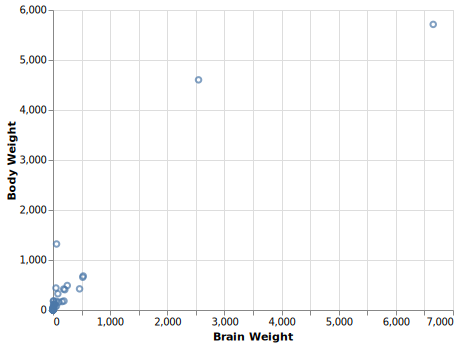

In [6]:
alt.renderers.enable('svg')
alt.Chart(dataframe).mark_point().encode(
    x=alt.X(field='Brain Weight',type='quantitative'),
    y=alt.Y(field='Body Weight', type='quantitative', sort='x')
)

Hmmm... It looks like the massive values are making it difficult to see the smaller ones. Let's only display a few values, to make viewing them easier.

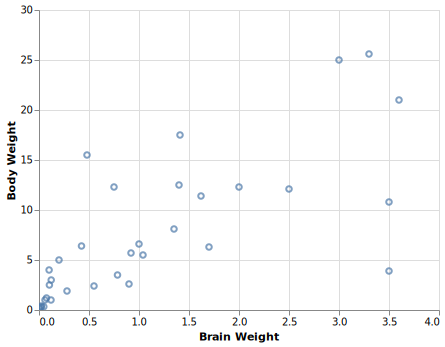

In [7]:
alt.Chart(dataframe).mark_point(clip=True).encode(
    x=alt.X(field='Brain Weight',type='quantitative',scale=alt.Scale(domain=(0,4))),
    y=alt.Y(field='Body Weight', type='quantitative', sort='x',scale=alt.Scale(domain=(0, 30)))
)

Well, there we go. You may notice a vague linear trend but we want to test for this mathematically.

We can also plot the graph with a ***log-log scale*** to view all the points on one graph.

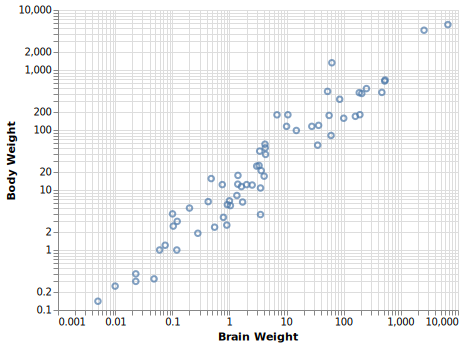

In [8]:
c1 = alt.Chart(dataframe).mark_point().encode(
    x=alt.X(field='Brain Weight',type='quantitative',scale=alt.Scale(type='log')),
    y=alt.Y(field='Body Weight', type='quantitative', sort='x',scale=alt.Scale(type='log'))
)
c1

Wow, that looks surprisingly linear. *BUT...* **Don't be deceived**. Linear regression runs on the underlying data values (rather than their log representations). And relationships of any form other than $ax^{n}$ will differ from their log-log plots E.g. the straight line y=x+10 below:

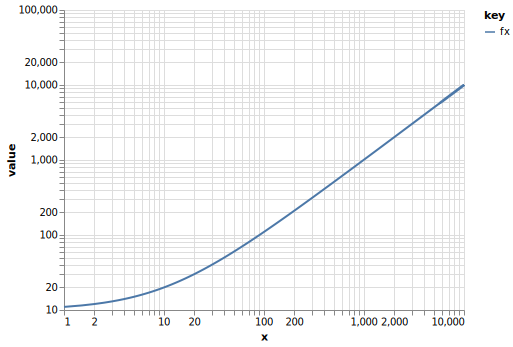

In [9]:
source = alt.sequence(start=1, stop=10000, step=0.5, as_='x')

alt.Chart(source).mark_line().transform_calculate(
    fx='datum.x+10',
).transform_fold(
    ['fx']
).encode(
    x=alt.X(field='x',type='quantitative',scale=alt.Scale(type='log')),
    y=alt.X(field='value',type='quantitative',scale=alt.Scale(type='log')),
    color='key:N'
)

### Approach via Simulated Annealing

Simulated annealing is an optimization technique (like gradient descent or hill-climbing) that helps to search for the global maxima/minima of a function. Compared with gradient descent or hill-climbing specifically, it is able to ***ignore local maxmima/minima*** and just ***find the global optima*** (given slow enough 'cooling'). 

So, let's define a loss function - the function that we want to minimise - to perform Ordinary Least Squares

In [10]:
#We'll define a loss function for ordinary least squares that takes arguments m and c

def loss_function(m,c):
    global dataframe

    y = lambda x: m*x + c
    
    ols = 0
    
    for index, row in dataframe.iterrows():
        ols += (row['Body Weight']-y(row['Brain Weight']))**2
    return ols


In [11]:
#Let's try one set of parameters out:
print(loss_function(20000,400))

2.070522112827237e+16


And now we can write a framework for ***Simulated Annealing***:

In [33]:
#Now, there is no way of sampling over all the real numbers, so let's define some bounds for our annealing
#And from simply looking at the data, the gradients nor intercepts cannot be ridiculously high - 
#Let's restrict them to +-50 and +-1000 respectively - simply from a graphical view of the data
bounds = {'m':[-50,50],'c':[-1000,1000]}

In [34]:
#Now, set an initial set of parameters for the system:
params = {'m':random.uniform(bounds['m'][0], bounds['m'][1]),'c':random.uniform(bounds['c'][0], bounds['c'][1])}
print(params)
cost = loss_function(params['m'],params['c'])

{'m': 33.69730251237911, 'c': 370.9804900283152}


In [35]:
def getRandomNeighbour(x,bounds,temperature):
    
    #Gets a random neighbour. Max step of 1/8*1/2 = 1*range/16.  
    
    valRange = temperature * (bounds[1] - bounds[0])/8
    d =  valRange * (random.random()-0.5)
    neighbour = x+d
    
    #Restricts neighbour values to within our range.
    if neighbour > bounds[1]:
        neighbour = bounds[1]
    if neighbour < bounds[0]:
        neighbour = bounds[0]
        
    return neighbour

def acceptanceFunction(cost, newCost, temperature):
    if newCost < cost:
        #Always descend if the cost is lower
        return 1
    else:
        #Simulated Annealing Probability must tend to zero as temperature tends to zero.
        #Lower probabilities for greater new costs.
        p = np.exp((cost-newCost)/temperature)
        return p


Great! Now that we've got our helper functions, we can execute ***Simulated Annealing*** over a number of iterations:

In [36]:
ITERATIONS = 10000
changes = []
for i in range(ITERATIONS):
    completion = i/ITERATIONS
    temp = max(0.01, min(1, 1 - completion))
    
    newM = getRandomNeighbour(params['m'],bounds['m'],temp)
    newC = getRandomNeighbour(params['c'],bounds['c'],temp)
    
    newCost = loss_function(newM,newC)
    
    
    
    if acceptanceFunction(cost,newCost,temp) > random.random():
        changes.append([i,newCost])
        params['m'] = newM
        params['c'] = newC
        cost = newCost
    
    

In [37]:
#Output discarded for being too large.
print(params)
print(loss_function(params['m'],params['c']))

{'m': 0.9666199783866358, 'c': 90.58371920229983}
6722249.536779261


   Iterations          Cost
0           0  5.375457e+10
1           2  3.868591e+10
2           3  3.401575e+10


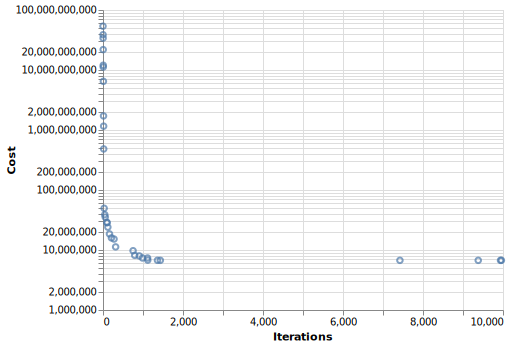

In [38]:
ser = pd.Series(changes)
frame = pd.DataFrame(ser.values.tolist(), index=ser.index,columns=["Iterations","Cost"])
print(frame.head(3))
alt.Chart(frame).mark_point().encode(
    x=alt.X(field='Iterations',type='quantitative'),
    y=alt.Y(field='Cost',type='quantitative',scale=alt.Scale(type='log'))
)


Wow! Look at that! After just 10000 iterations (taking a minute or two), the simulation has seemed to hone in on some values pretty clearly. 

$$ y = 0.96662x + 90.584 $$

Let's examine them on the graph:

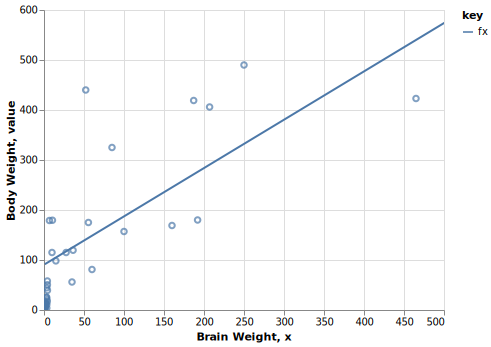

In [39]:
source = alt.sequence(start=1, stop=10000, step=0.5, as_='x')

c1 = alt.Chart(dataframe).mark_point(clip=True).encode(
    x=alt.X(field='Brain Weight',type='quantitative',scale=alt.Scale(domain=(0, 500))),
    y=alt.Y(field='Body Weight', type='quantitative',scale=alt.Scale(domain=(0, 600)))
)


c2 = alt.Chart(source).mark_line(clip=True).transform_calculate(
    fx='0.9666199783866358*datum.x+90.58371920229983',
).transform_fold(
    ['fx']
).encode(
    x=alt.X(field='x',type='quantitative',),
    y=alt.X(field='value',type='quantitative',),
    color='key:N'
)
alt.layer(c1,c2)

We can also try running with a few more iterations:

In [ ]:
#Now, set a new initial set of parameters for the system:
params = {'m':random.uniform(bounds['m'][0], bounds['m'][1]),'c':random.uniform(bounds['c'][0], bounds['c'][1])}
cost = loss_function(params['m'],params['c'])

ITERATIONS = 100000
changes = []
for i in range(ITERATIONS):
    completion = i/ITERATIONS
    temp = max(0.01, min(1, 1 - completion))
    
    newM = getRandomNeighbour(params['m'],bounds['m'],temp)
    newC = getRandomNeighbour(params['c'],bounds['c'],temp)
    
    newCost = loss_function(newM,newC)
    
    
    if acceptanceFunction(cost,newCost,temp) > random.random():
        changes.append([i,newCost])
        params['m'] = newM
        params['c'] = newC
        cost = newCost
    

In [29]:
print(params)
print(loss_function(0.9659362423807267,91.29398751426505))

{'m': 0.9659362423807267, 'c': 91.29398751426505}
6722256.498220906


Interesting... These extra iterations didn't even improve our result (cost) but took 10 times longer. There are a number of factors at play:
* Simulated Annealing is a complex process with many different parameters that can be tweaked (e.g. the form of our probability function and range scaling factors) and general optimizations. 
* It is a stochastic (rather than deterministic) process so it's entirely possible to have a bad run/bad initial values and get poor results.

Also of note: We permitted the variables to change within fairly large domains. This means that more iterations are needed to get the same level of granularity for each variable. This is almost like a 'resolution'.

So, the best regression we obtained (the one with the lowest cost) was:

$$ y = 0.96594x + 91.2940 $$ 


### Approach via Statistical Methods

The statistical method approach involves slightly more maths but in exchange, we receive a far cleaner solution.

A full derivation is provided in **[3]**, but, in summary:


$$ Q = \sum_{i=1}^{n} (y_i - a - bx_i)^2 $$

Q will be minimized when 
$$ \frac{\partial Q}{\partial a} = 0 \quad [1] \quad and \quad \frac{\partial Q}{\partial b} = 0 \quad [2] $$

Expanding and simplifying [1] produces

$$ \hat{a} = \bar{Y} - \hat{b}\bar{X},\space where \space \hat{a},\hat{b}\space are\space minimising \space values$$

Expanding and simplifying [2] produces

$$ \hat{b} = \frac{Covariance(X,Y)}{Variance(X)} $$

Now, covariance is given by the following formula:

$$ Cov(X,Y) = \frac{\sum_{i=1}^{n}(x_{i}-\bar{x})(y_{i}-\bar{y})}{n} $$ 

And for variance:

$$ Var(X) = \frac{\sum_{i=1}^{n}(x_{i}-\bar{x})^2}{n} $$ 

*Note: These refer to **population variance and covariance**. We are using these because we are performing regression over the whole dataset - a population - (not the observed system).*

So, let's perform the calculation:

In [17]:
xtotal = 0
ytotal = 0
count = 0
covariance = 0
variance = 0
for index, row in dataframe.iterrows():
    xtotal += row['Brain Weight']
    ytotal += row['Body Weight']
    count +=1
xmean = xtotal / count
ymean = ytotal / count
for index, row in dataframe.iterrows():
    x = row['Brain Weight']
    y = row['Body Weight']
    covariance += (x-xmean)*(y-ymean)
    variance += (x-xmean)**2
variance /= count
covariance /= count
b = covariance/variance
print("Variance: " + str(variance))
print("Covariance: " + str(covariance))
print("b (Gradient): " + str(b))
print("a (Intercept): " + str(ymean-b*xmean))

Variance: 795445.0451699513
Covariance: 768794.7468399063
b (Gradient): 0.9664963676725763
a (Intercept): 91.00439620740684


In [21]:
#Loss Value
loss_function(0.9664963676725763,91.00439620740684)

6722239.055504982

And look at that! The proven statistical values match the simulation-derived ones pretty closely:

$$ y = 0.96662x + 90.584 \quad Cost: \space 6722250$$

$$ vs. $$

$$ y = 0.96650x + 91.004 \quad Cost: \space 6722239$$

So the cost values only differ by ≈11 which doesn't seem bad given the massive cost values passed over during simulation.

And yes, there are a whole bunch of things I haven't covered here - R^2 Coefficients, Multivariate Linear Regression, Non-Linear Regression - but this notebook is already beginning to drag! 

Even simple, ordinary Linear Regression is a powerful tool; ***Use it Wisely!***

______________
Stay tuned to my ***Github*** - [HydraulicSheep](https://github.com/HydraulicSheep) - for explorations of more great ***Game Theory*** and ***Statistics*** content.